In [1]:
import io
import os
import os.path as osp
import pandas as pd

os.chdir(os.path.dirname(os.getcwd()))
from helpers import *
from configs import *
from google.cloud import vision
from tqdm import tqdm
from PIL import Image
from glob import glob

print("Current directory: ", os.getcwd())

Current directory:  /home/ntnhu/projects/VideoFall-VBS2022


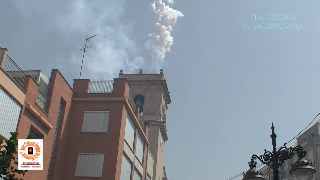

In [3]:
Image.open(osp.join(KEYFRAME_PATH, '08142/shot08142_76_RKF.png'))

### Provided V3C1-OCR

https://github.com/klschoef/V3C1Analysis

In [38]:
V3C1_OCR_path = osp.join(DATASET_MASTER_PATH, 'provided_ocr/V3C1_ocr')
allshots_filename = osp.join(V3C1_OCR_path, 'msb-allshots.txt')
allshots_indices_filename = osp.join(V3C1_OCR_path, 'msb-allshots-indices.txt')
type_filename = 'muchtext'
text_filename = osp.join(V3C1_OCR_path, f'{type_filename}.txt')
text_keyframe_filename = osp.join(V3C1_OCR_path, f'{type_filename}_keyframes.txt')
V3C1_OCR_keyframes_filename = osp.join(DATASET_MASTER_PATH, 'OCR/V3C1_OCR_keyframes.txt')

#### Add indices into file msb

In [7]:
with open(allshots_filename, 'r') as file:
    allshots = file.read().splitlines()
    allshots.pop(0)
    allshots = sort_list(allshots)

In [15]:
curr_video_idx = int(allshots[0][:5])
index = 1
for i, item in enumerate(tqdm(allshots)):
    video_idx = int(item[:5])
    if video_idx > curr_video_idx:
        index = 1
        curr_video_idx = video_idx
    allshots[i] = ';'.join([item[:5], item[10:], str(index)])
    index = index + 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1082657/1082657 [00:00<00:00, 1429069.47it/s]


In [16]:
with open(allshots_indices_filename, 'w') as file:
    file.write('video;startframe;endframe;keyframe;index\n')
    file.writelines('\n'.join(allshots))

#### Convert provided OCR file into shot name file

In [3]:
with open(allshots_indices_filename, 'r') as file:
    shot_indices = file.read().splitlines()
    shot_indices.pop(0)
    shot_indices = sort_list(shot_indices)

# Convert shots with indices into dictionary for later user
shot_indices_dict = {}
for item in tqdm(shot_indices):
    item_list = item.split(';')
    index = '{0}/{0}_{1:07d}'.format(item_list[0], int(item_list[3]))
    shot_indices_dict[index] = item_list[-1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1082657/1082657 [00:00<00:00, 1147108.97it/s]


In [4]:
with open(text_keyframe_filename, 'r') as file:
    text = file.read().splitlines()
    text.pop(0)
    text = sort_list(text)

In [5]:
name_list = []
for item in tqdm(text):
    video = item[:5]
    index = shot_indices_dict[item]
    name = '{0}/shot{0}_{1}_RKF.png'.format(video, index)
    name_list.append(name)

with open(text_keyframe_filename, 'w') as file:
    file.writelines('\n'.join(name_list))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18861/18861 [00:00<00:00, 1043623.75it/s]


#### Save V3C1 OCR keyframes file

In [39]:
OCR_filename = osp.join(DATASET_MASTER_PATH, 'OCR/OCR_V3C1.json')
with open(osp.join(V3C1_OCR_path, 'muchtext_keyframes.txt'), 'r') as file:
    muchtext_keyframes = file.read().splitlines()
with open(osp.join(V3C1_OCR_path, 'fewtext_keyframes.txt'), 'r') as file:
    fewtext_keyframes = file.read().splitlines()
    
text_keyframes = fewtext_keyframes + muchtext_keyframes
v3c1_ocr_names = sort_list(text_keyframes)

In [41]:
with open(V3C1_OCR_keyframes_filename, 'w') as file:
    file.writelines('\n'.join(v3c1_ocr_names))

#### Read V3C1 OCR keyframes

In [56]:
with open(V3C1_OCR_keyframes_filename, 'r') as file:
    v3c1_ocr_names = file.read().splitlines()

### Provided V3C2-OCR

https://github.com/lucaro/V3C2Analysis

In [34]:
V3C2_OCR_path = osp.join(DATASET_MASTER_PATH, 'provided_ocr/V3C2_ocr')
video_names = glob(osp.join(V3C2_OCR_path, '*.json'))
V3C2_OCR_keyframes_filename = osp.join(DATASET_MASTER_PATH, 'OCR/V3C2_OCR_keyframes.txt')

#### Save V3C2 OCR keyframes file

In [48]:
v3c2_ocr_names = []
for video_name in tqdm(video_names):
    video = video_name.split('/')[-1][:5]
    easyocr = load_json(video_name)
    keys = list(easyocr.keys())
    if len(keys) != 0:
        for key in keys:
            v3c2_ocr_names.append('{0}/shot{0}_{1}_RKF.png'.format(video, key))
v3c2_ocr_names = sort_list(v3c2_ocr_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9760/9760 [00:21<00:00, 450.68it/s]


In [49]:
with open(V3C2_OCR_keyframes_filename, 'w') as file:
    file.writelines('\n'.join(v3c2_ocr_names))

#### Read V3C2 OCR keyframes

In [52]:
with open(V3C2_OCR_keyframes_filename, 'r') as file:
    v3c2_ocr_names = file.read().splitlines()

In [55]:
len(v3c2_ocr_names)

425919

### Google API

In [32]:
# OCR_filename = osp.join(DATASET_MASTER_PATH, 'OCR/OCR_V3C1.json')
# with open(osp.join(V3C1_OCR_path, 'muchtext_keyframes.txt'), 'r') as file:
#     muchtext_keyframes = file.read().splitlines()
# with open(osp.join(V3C1_OCR_path, 'fewtext_keyframes.txt'), 'r') as file:
#     fewtext_keyframes = file.read().splitlines()
    
# text_keyframes = fewtext_keyframes + muchtext_keyframes
text_keyframes = sort_list(text_keyframes)

In [33]:
len(text_keyframes)

122794

In [5]:
# Path to the Credential json (download from GG)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/ntnhu/projects/VideoFall-VBS2022/OCR/vbs-ocr.json" 

def convert_response_to_list(res):
    texts = res.text_annotations
    result = []
    for text in texts:
        di = dict()
        di['text'] = text.description
        di['bb'] = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        result.append(di)
    return result

# Declare API
client = vision.ImageAnnotatorClient()

In [ ]:
OCR_dict = {}
for img_id in tqdm(text_keyframes):
    path = osp.join(KEYFRAME_PATH, img_id)

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    # Run API (its free 1000 times/month --> later 1.5 / 1000 calls)
    response = client.text_detection(image=image)
    texts = [text.description for text in response.text_annotations]
    ocr = ' '.join(texts)
    ocr = ocr.replace('\n', ' ')
    ocr = re.sub(' +', ' ', ocr)
    OCR_dict[img_id] = ocr

In [8]:
with open(OCR_filename, 'w') as fp:
    json.dump(OCR_dict, fp, indent=4)